In [1]:
import sys
sys.path.append('../')
import logging
import matplotlib.pyplot as plt
import random
import numpy as np
from rdkit import Chem, SimDivFilters, DataStructs
from rdkit.Chem import Draw, rdMolDescriptors, AllChem
from rdkit.SimDivFilters import rdSimDivPickers
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

logging.basicConfig(format = '%(levelname)s - %(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level = logging.ERROR)

from bbSelect import Picker

plt.rcParams['figure.figsize'] = [15,10]


In [2]:
# To do
# Set up conda environment
    # To simplify the environments:
    # Ensure that
    # conda env create --name myenv -f environment.yml
    # example : https://github.com/gsk-tech/olivecrona-RNN/blob/master/packages.yml
    # mamba vs conda.

# Comparison of Selection algorithms for a selection of 48 compounds

The purpose of this notebook is to show a comparison of different methods to select n from a set of R-groups.<br>
The methods that will be compared are:
 - The bbSelect 'som' and 'classic' selection methods
 - k-means clustering method (selecting centroids)
 - The Sphere exclusion method (selecting centroids)
 - The MaxMin selection method (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598)
 - Random selection
 
Analyses will be performed for each selection method
- For each method, the selection will be shown, followed by the coverage according to mGAP
- This is followed by a comparison of the Tanimoto similarities of each of the selection methods
- This is followed by a comparison of the physicochemical property distribution of the set


In [3]:
input_ref = '../data/enamine_acids/enamine_acids_filtered_omega.ref'
input_bin = '../data/enamine_acids/enamine_acids_filtered_omega.bin'
n_select = 48

## bbGAP self-organising map partitioning method
This is a selection method based on pharmacophore placement
- mGAP code located in mGapDBprocess.py, with a picker object similar to those used in RDKit
- Because some compounds fail conformer generation (due to bad smiles / stereochemistry which is not allowed), the compounds that pass will be used as the basis for the other selection methods

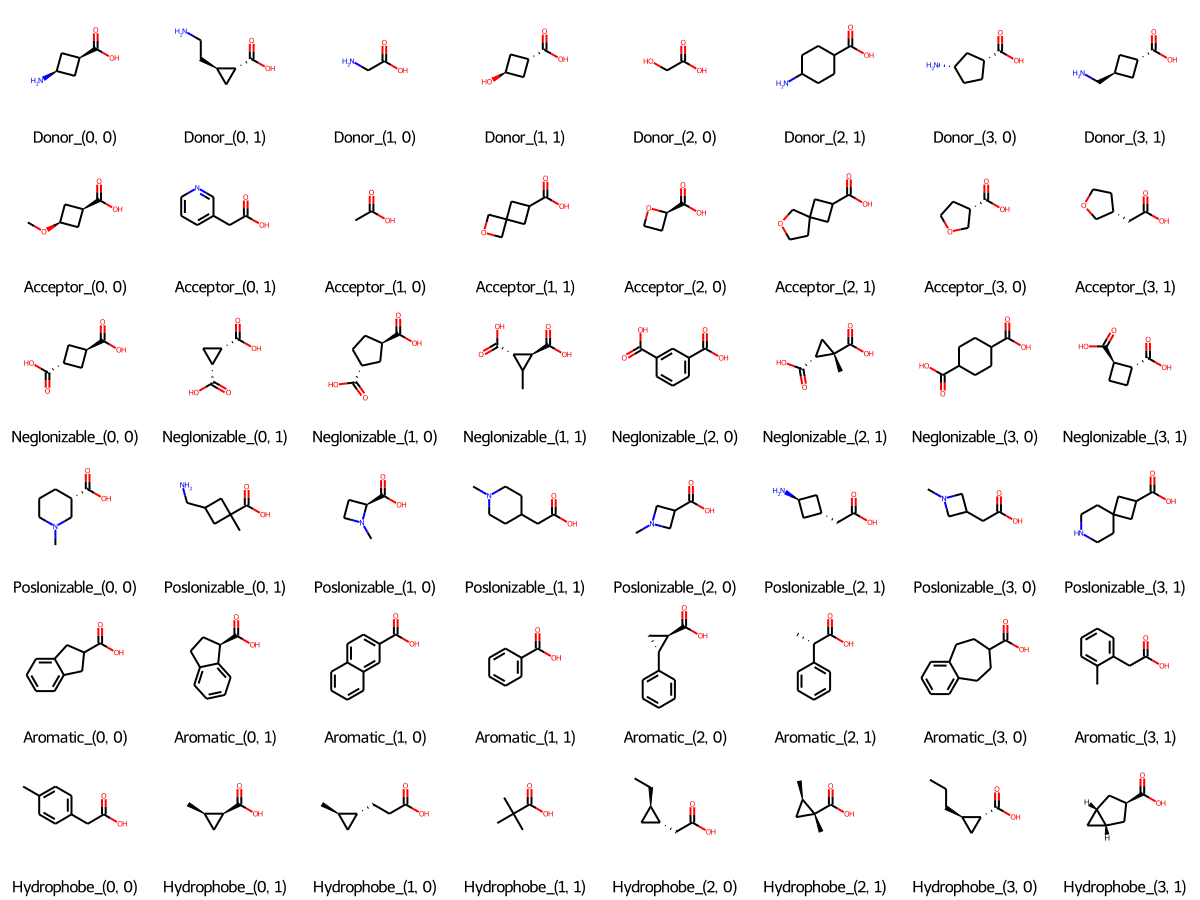

In [4]:
# run the bbGAP selection, using the SOM method
som_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = n_select,  # How many compounds to select
                          method = 'som', # Which clustering method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0.9,
                            use_coverage = False,)

#mGAPclustering = mGAP_selection._mGAPclustering 
som_selected_smiles_dict = som_selection.GetSelectionDict()
som_selected_molnames = som_selection.GetSelectionIDs()
## Get all smiles and molnames from the set
smiles = som_selection.GetAllSmiles()
molnames = som_selection.GetAllIds()
#list(mGAP_selection._selection_table.index
som_selection.DrawSelectedMols(align_smiles = 'CC(=O)O', fontsize = 16)

In [5]:
som_selection.GetDataTable()['MPO'].loc[som_selected_molnames].mean()

0.17525584547224435

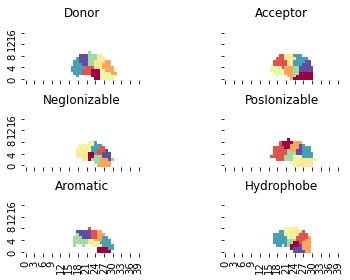

In [6]:
## View the clustering performed by mGAP
fig = som_selection.VisualisePartitioning()

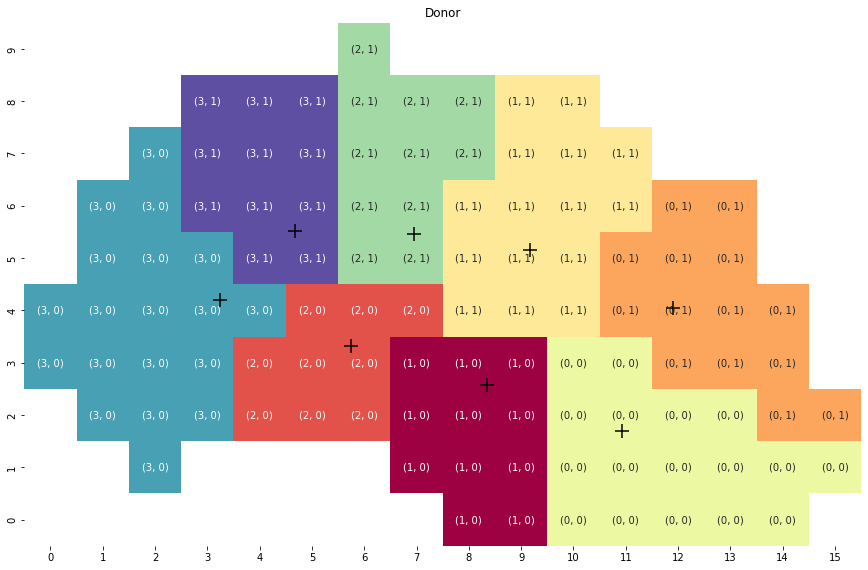

In [7]:
som_selection.VisualisePartitioningDetail(pharmacophore = 'Donor')

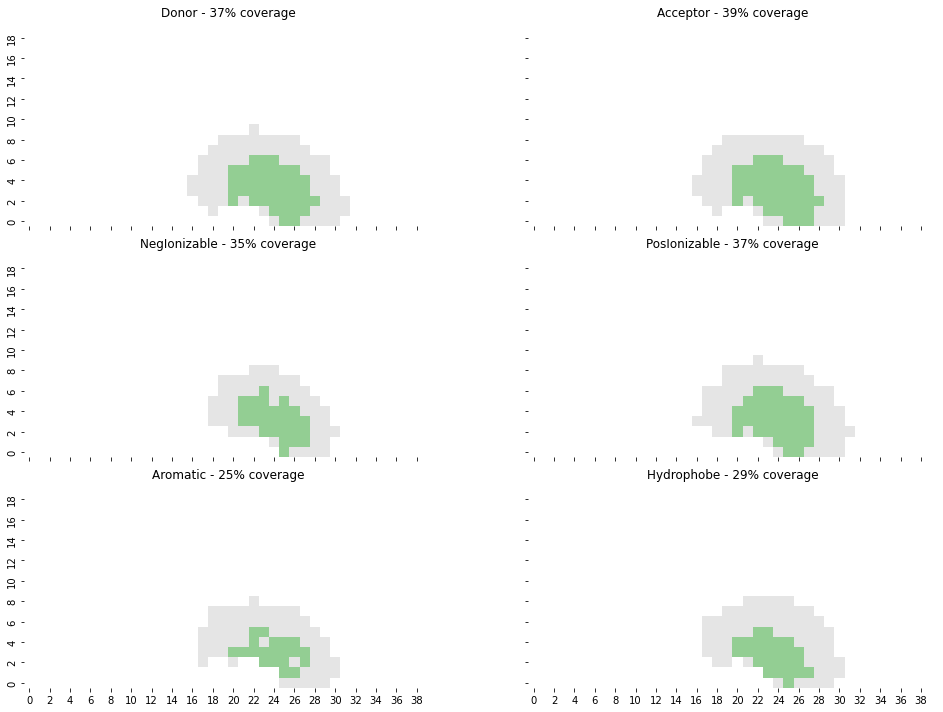

In [8]:
## mGAP coverage
fig = som_selection.VisualiseCoverage()

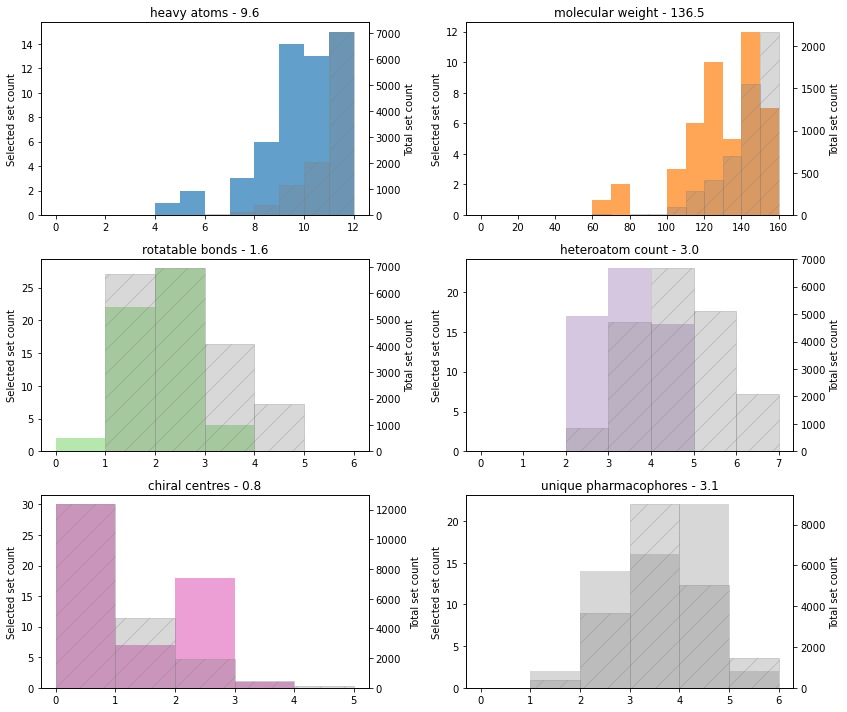

In [9]:
fig = som_selection.VisualisePropertyDistribution()

## bbGAP classic partitioning method

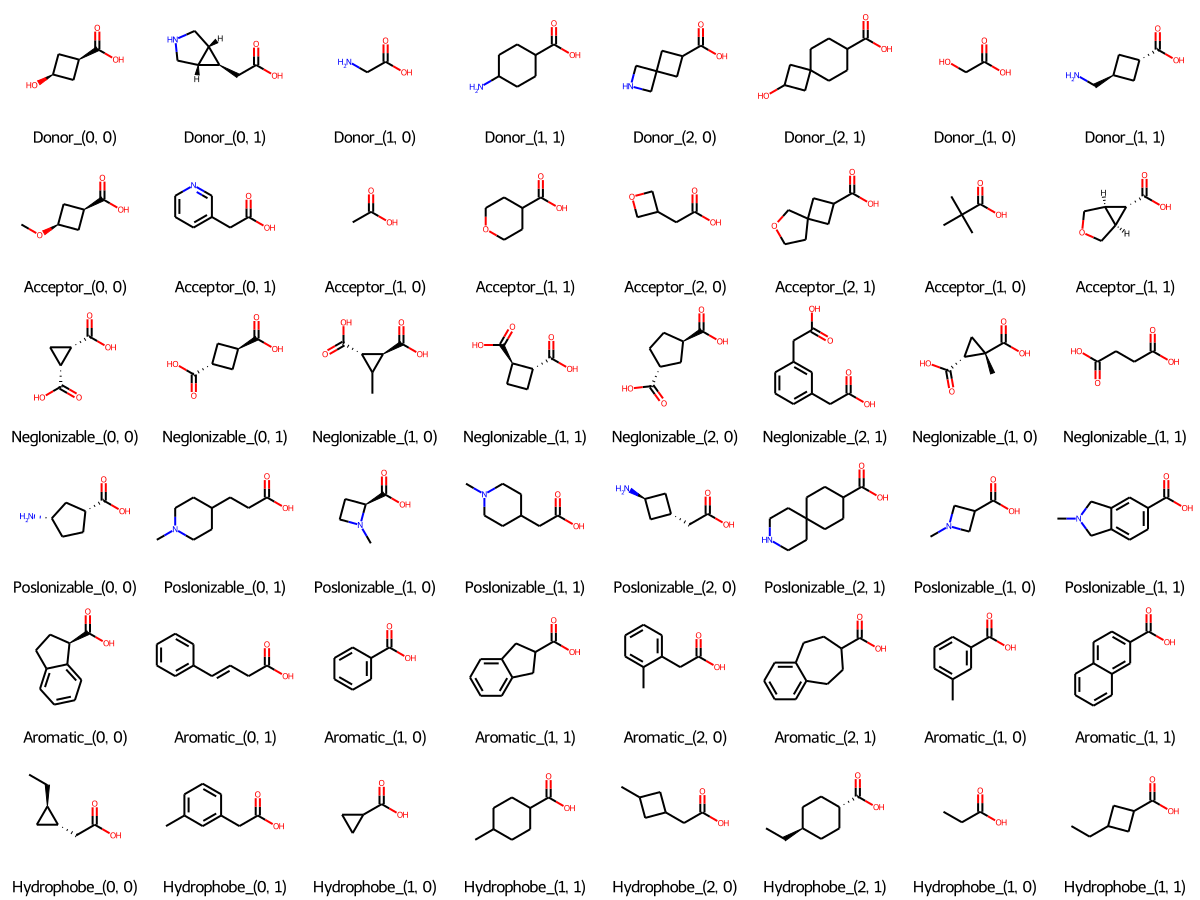

In [10]:
classic_selection = Picker(ref_file = input_ref, 
                            bin_file = input_bin, 
                            n = n_select,  # How many compounds to select
                            method = 'classic', # Which clustering method to use
                            pharmacophores = '*', # Which pharmacophore to select from,
                            select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            sort = 'MPO',
                            ncpu = 15,
                          use_coverage = False)

## Get smiles as a list
#smiles = list(classic_selection._selection_table['smiles'])
#molnames = list(classic_selection._selection_table.index)
classic_selected_smiles_dict = classic_selection.GetSelectionDict()
classic_selected_molnames = classic_selection.GetSelectionIDs()
classic_selection.DrawSelectedMols(align_smiles = 'CC(=O)O', fontsize = 16)

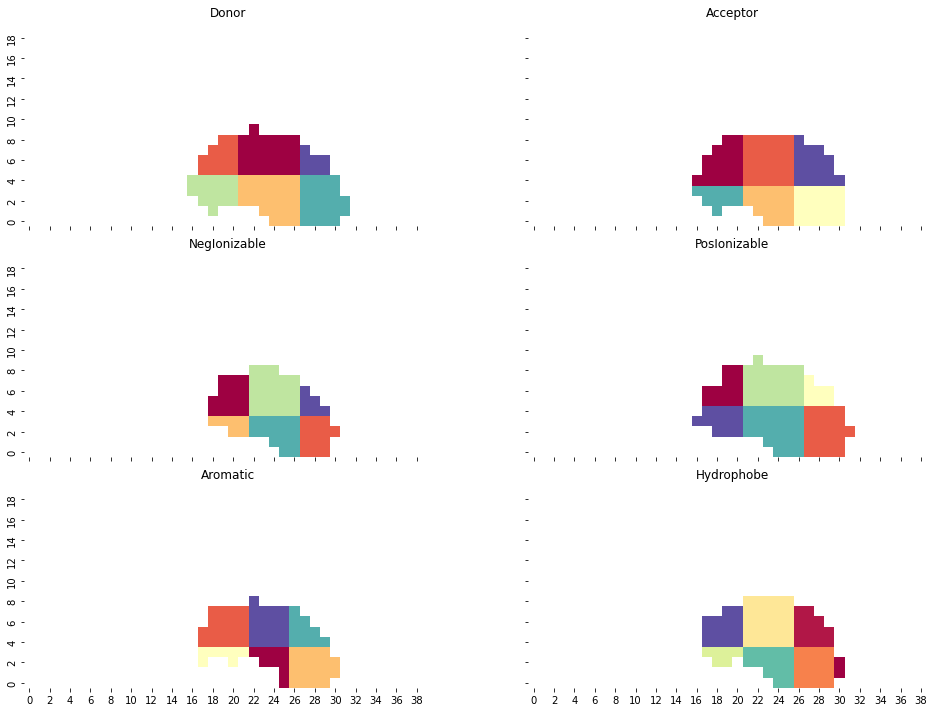

In [11]:
## View the clustering performed by mGAP
fig = classic_selection.VisualisePartitioning()

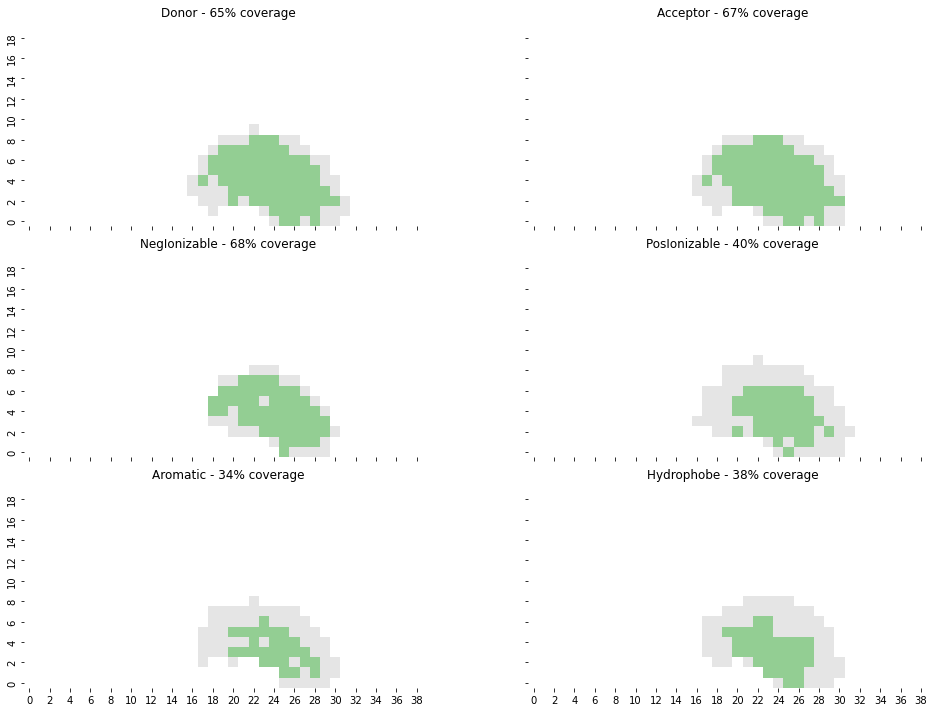

In [12]:
fig = classic_selection.VisualiseCoverage()

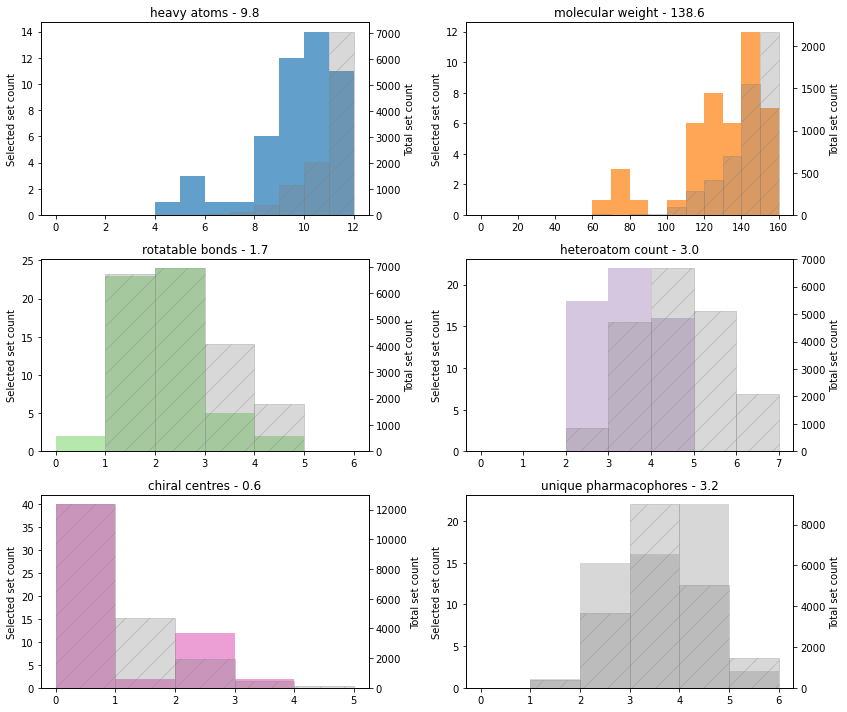

In [13]:
fig = classic_selection.VisualisePropertyDistribution()

## SOM partitioning with coverage

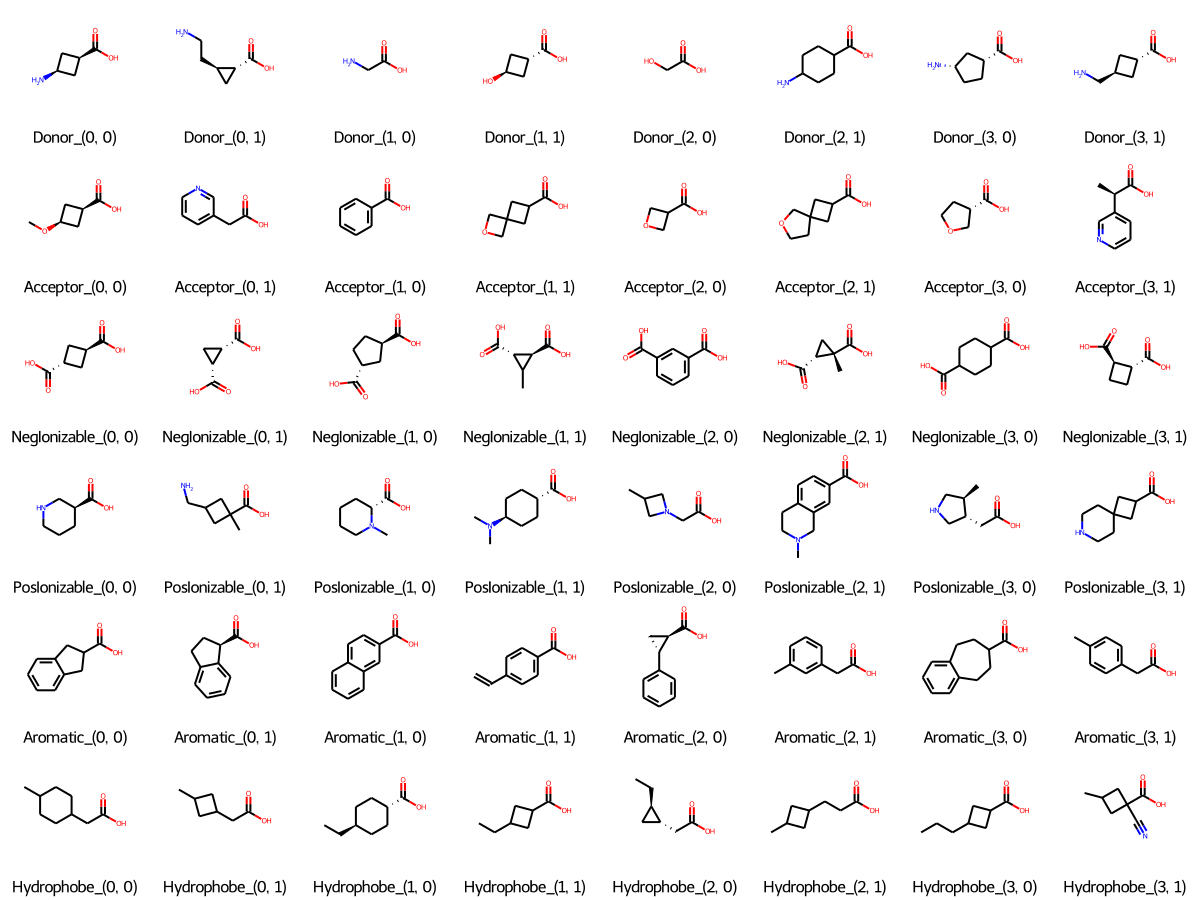

In [14]:
# run the bbGAP selection, using the SOM method
som_coverage_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = n_select,  # How many compounds to select
                          method = 'som', # Which clustering method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0.9,
                            use_coverage = True,)

#mGAPclustering = mGAP_selection._mGAPclustering 
som_selected_coverage_smiles_dict = som_coverage_selection.GetSelectionDict()
som_selected_coverage_molnames = som_coverage_selection.GetSelectionIDs()
#list(mGAP_selection._selection_table.index
som_coverage_selection.DrawSelectedMols(align_smiles = 'CC(=O)O', fontsize = 16)

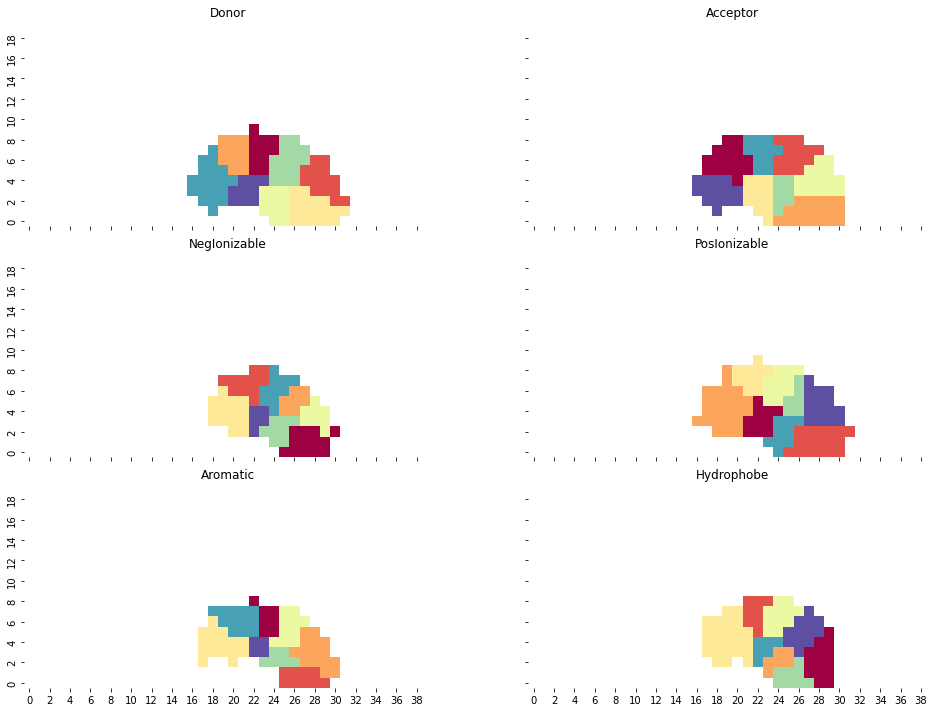

In [15]:
## View the clustering performed by mGAP
fig = som_coverage_selection.VisualisePartitioning()

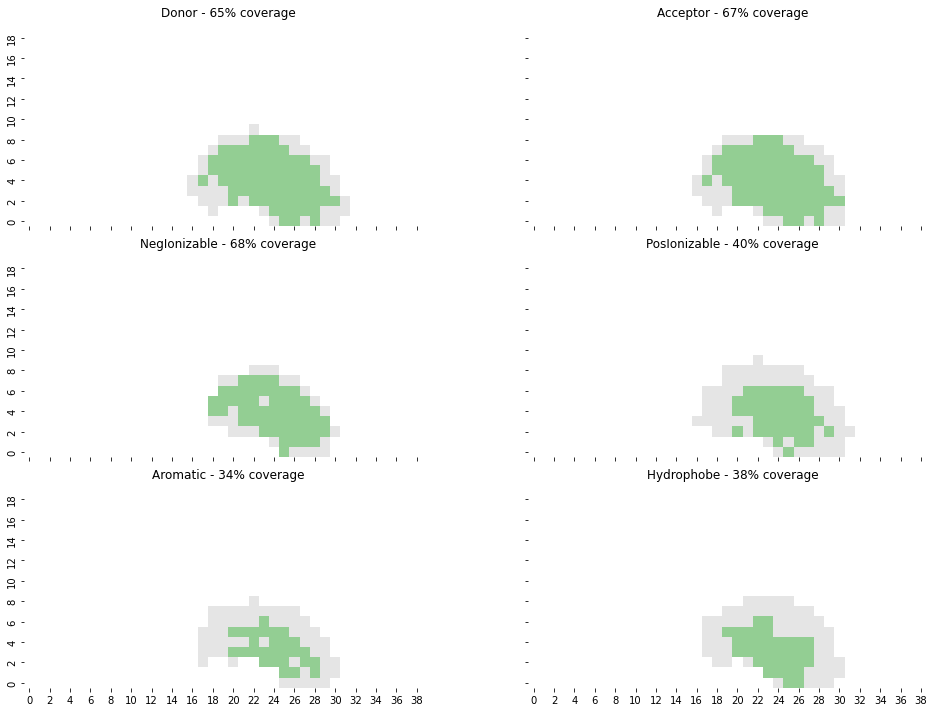

In [16]:
fig = classic_selection.VisualiseCoverage()

In [17]:
## Classic partitioning with coverage

## Full coverage

In [18]:
full_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = 1,  # How many compounds to select
                          method = 'full_coverage', # Which partitioning method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                        select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0)

full_selected_smiles_dict = full_selection.GetSelectionDict()
full_selected_molnames = full_selection.GetSelectionIDs()

print(f'full coverage achieved with {len(full_selected_molnames)} picks')
mpo_mean = full_selection.GetDataTable()['MPO'].loc[full_selected_molnames].mean()
print(f'MPO mean : {mpo_mean}')
full_selection.DrawSelectedMols(align_smiles = 'CC(=O)O')


full coverage achieved with 240 picks
MPO mean : 0.24842958571728846


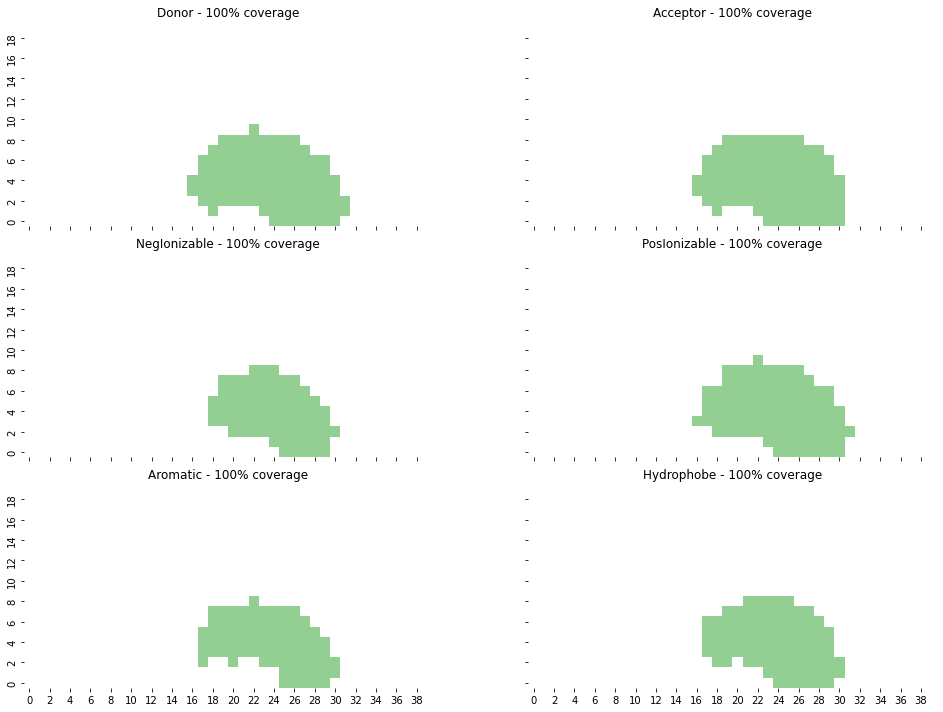

In [19]:
fig = full_selection.VisualiseCoverage()

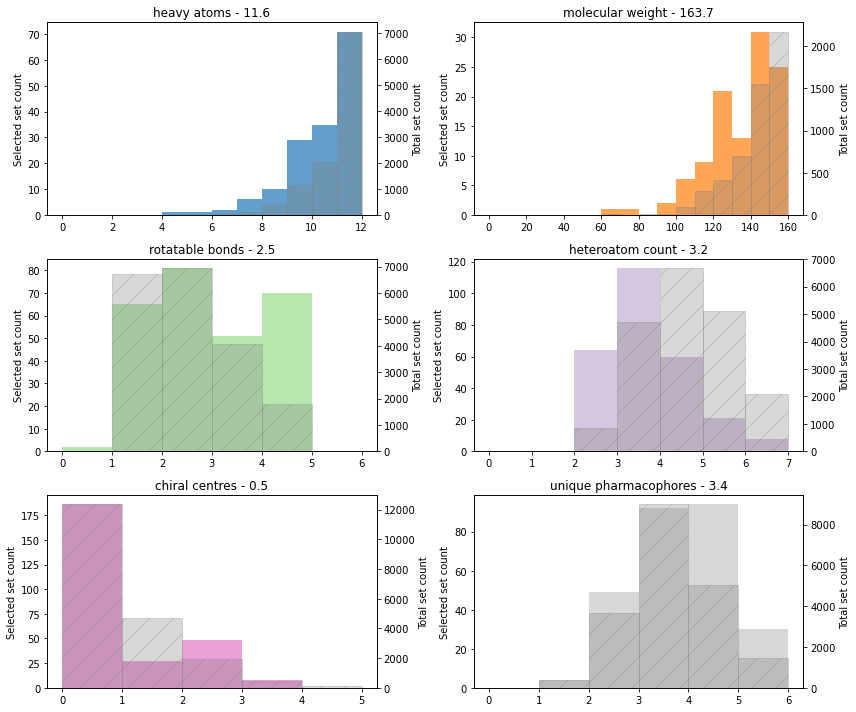

In [20]:
fig = full_selection.VisualisePropertyDistribution()

In [21]:
## Get the molecule objects as a list for non bbSelect selections
mols = []
align_mol = Chem.MolFromSmiles('CC(=O)O')
AllChem.Compute2DCoords(align_mol)
for sm, ID in zip(smiles, molnames):
    mol = Chem.MolFromSmiles(sm)
    AllChem.GenerateDepictionMatching2DStructure(mol , align_mol)
    mols.append(mol)

## Random selection
> - Take a random sample of compounds from the set

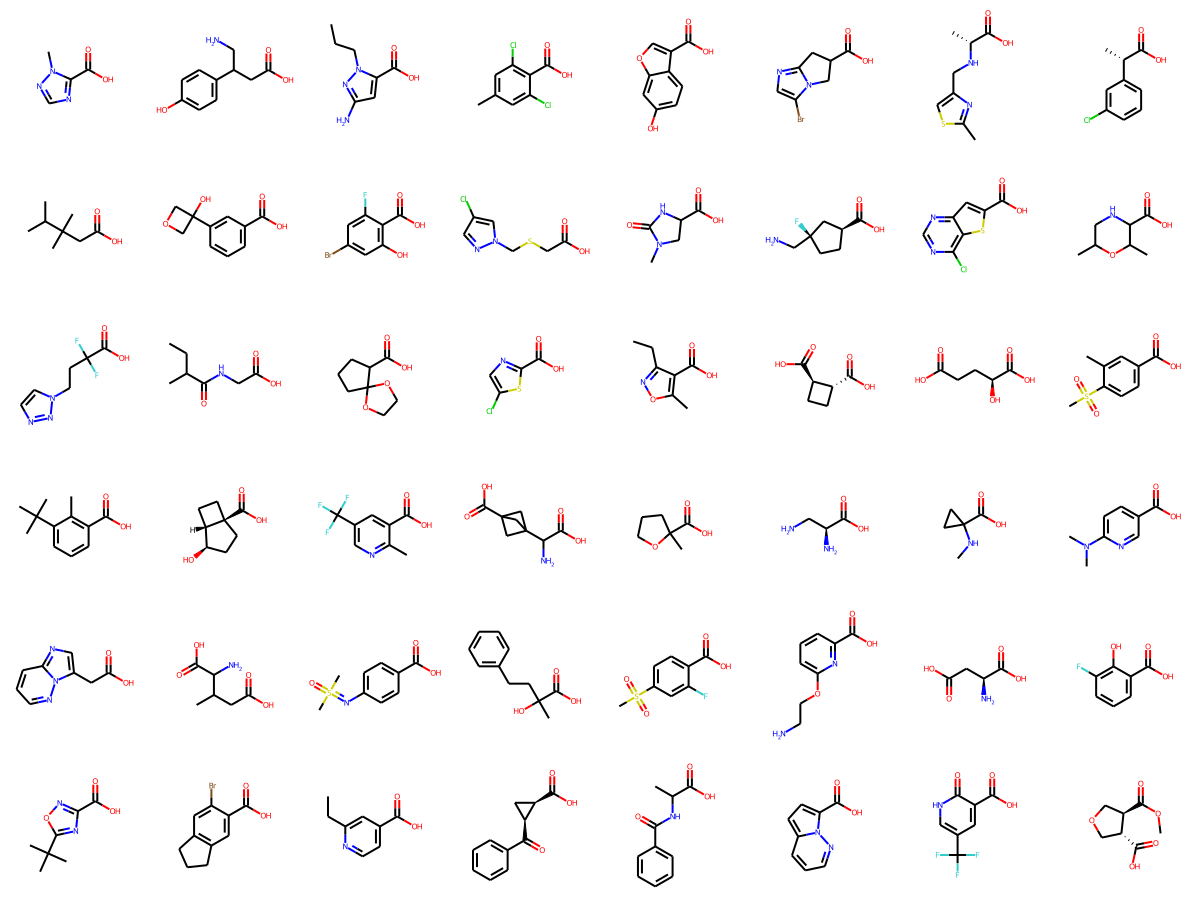

In [22]:
## Get random selection
molnames = list(som_selection._selection_table.index)
random.seed(3)
random_picks = random.sample([i for i,j in enumerate(mols)], n_select)
random_molnames = [molnames[x] for x in random_picks]
Draw.MolsToGridImage([mols[x] for x in random_picks], molsPerRow=8, maxMols=100, subImgSize=(150,150))

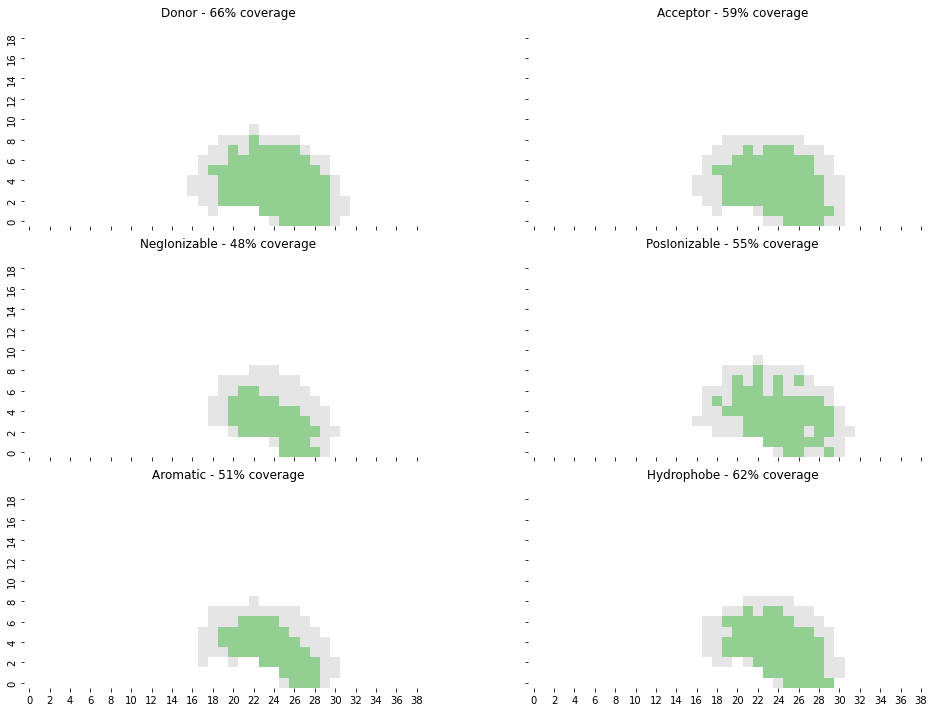

In [23]:
## Random coverage
coverage = classic_selection.SimulateCoverage(molnames = random_molnames)

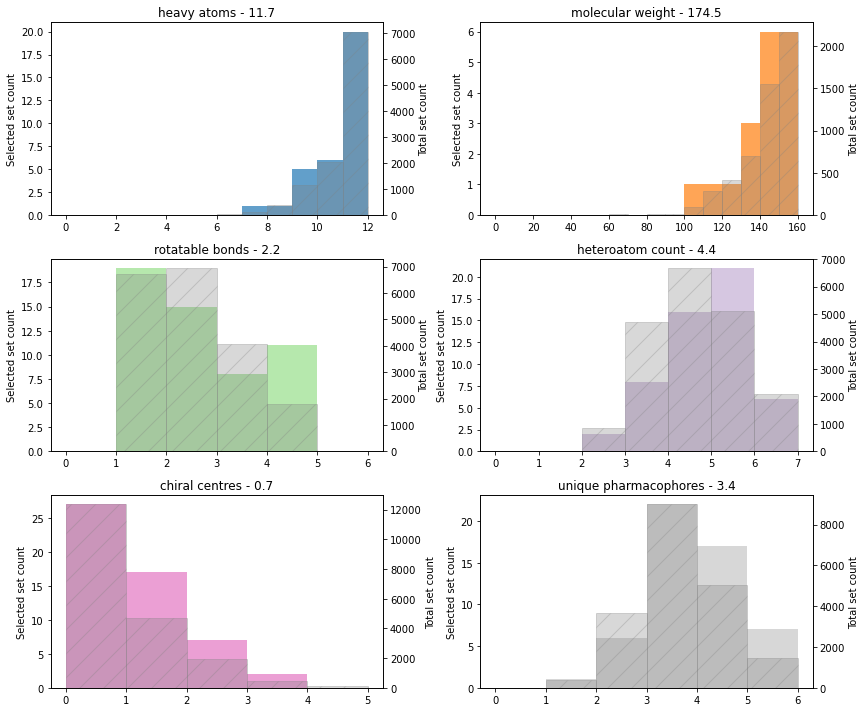

In [24]:
fig = classic_selection.VisualisePropertyDistribution(override_selected_IDs = random_molnames)

## Sphere-exclusion clustering

> - Butina method from rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html
> - Refs:
>> - D. Butina,          J. Chem. Inf. Comput. Sci. 1999, 39, 747
>> - A. Gobbi, M. Lee,   J. Chem. Inf. Comput. Sci. 2003, 43, 1, 317
>> - R. Sayle            https://raw.githubusercontent.com/rdkit/UGM_2019/master/Presentations/Sayle_Clustering.pdf


In [25]:
[12,24,36,48,60,72,96,128,160,200,250]

[12, 24, 36, 48, 60, 72, 96, 128, 160, 200, 250]

52


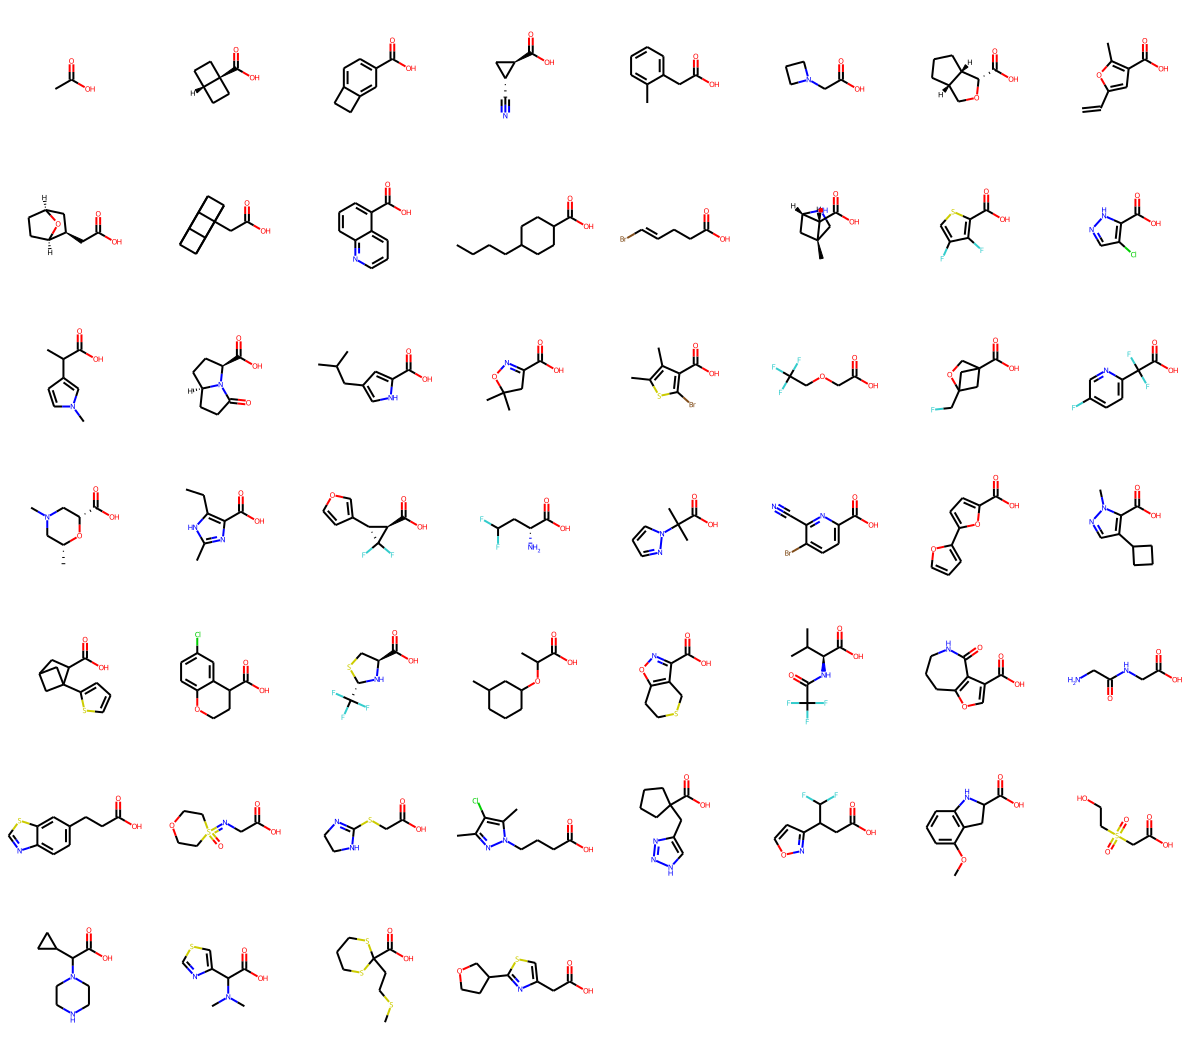

In [26]:
## Calculate fingerprints
## Equivalent to ECFP4 (diameter used in ECFP, radius used in Morgan)
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048) for m in mols]

## Start LeaderPicker object. This performs a fast sphere exclusion clustering without calculating similarity matrix
lp = rdSimDivPickers.LeaderPicker()

## Set similarity threshold for sphere exclusion clustering (minimum distance between cluster centroids)
thresh = 0.79

## Get 'picks' which are essentially the cluster centroids, giving the indices in the list of molecules of the selected compounds
sphex_picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(sphex_picks))
sphex_molnames = [molnames[x] for x in sphex_picks]
Draw.MolsToGridImage([mols[x] for x in sphex_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


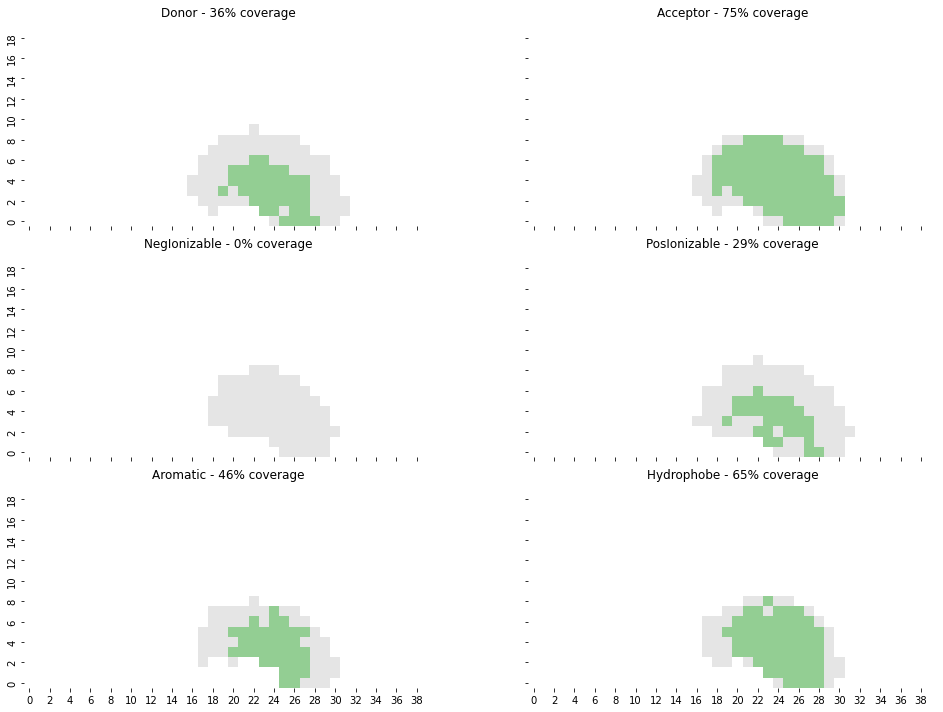

In [27]:
## Sphex coverage
coverage = classic_selection.SimulateCoverage(molnames = sphex_molnames)

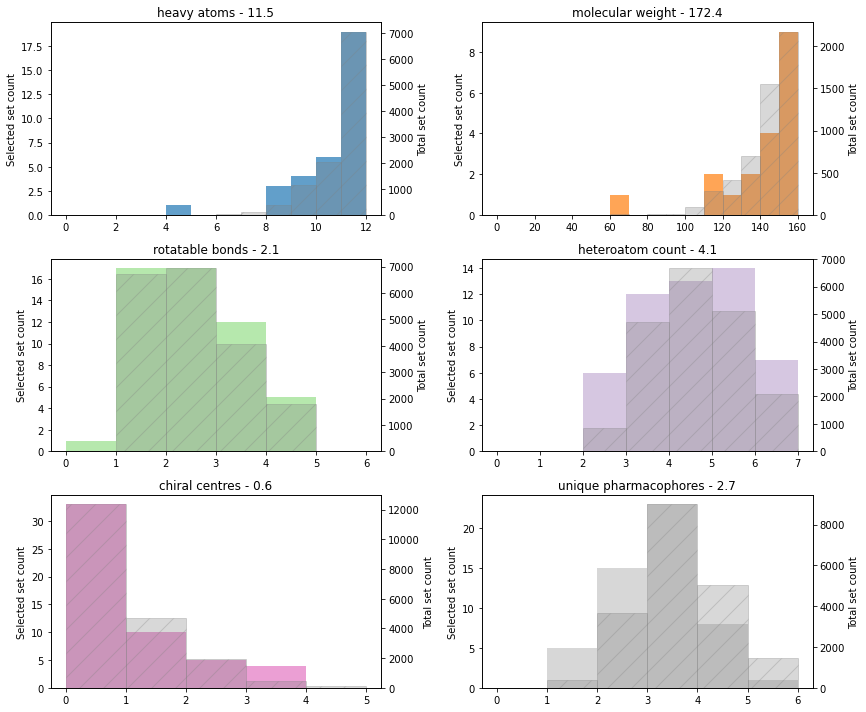

In [28]:
fig = classic_selection.VisualisePropertyDistribution(override_selected_IDs = sphex_molnames)

## MaxMin picker
> - MaxMin picker algorithm taken from http://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html and https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb
> - Picks things on edge of space. Is in paper Agrafiotis
> - refs:
>> - Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb

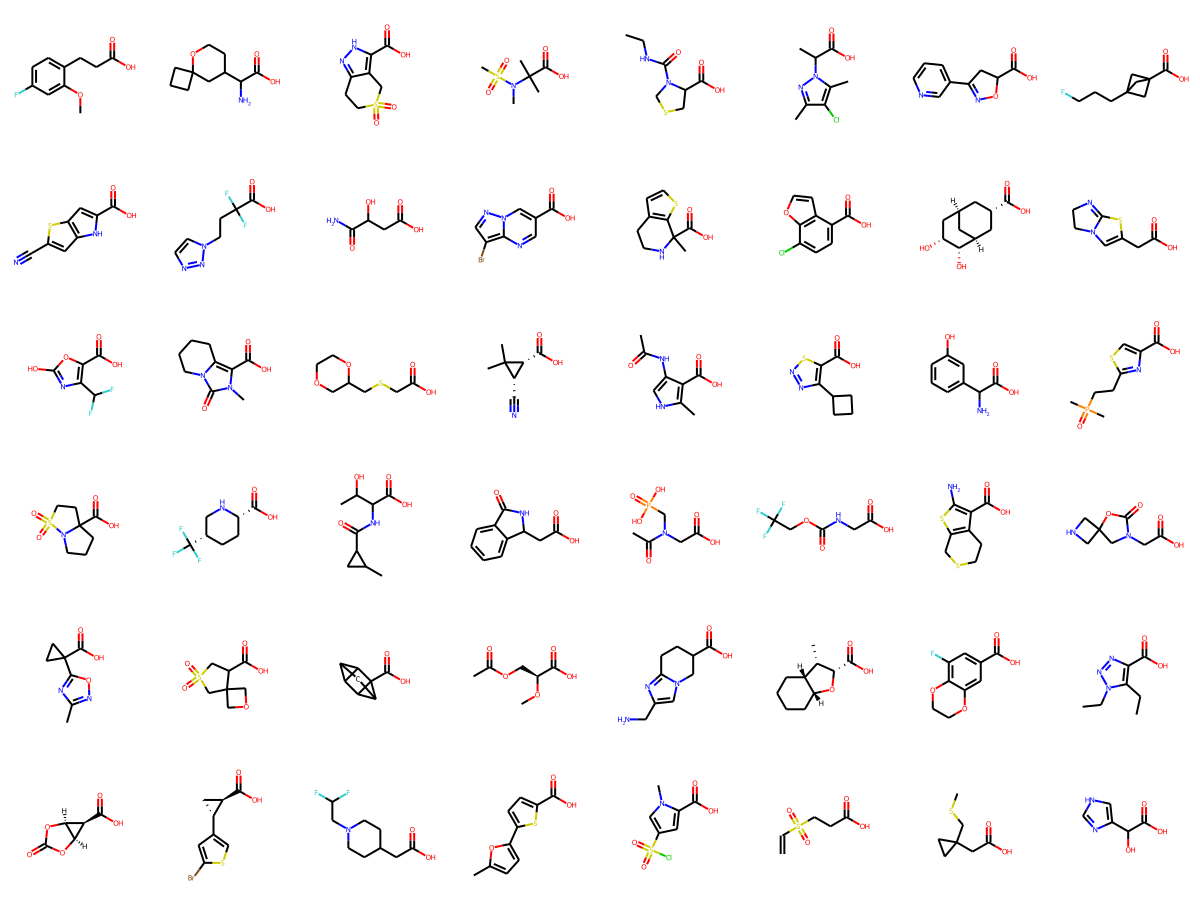

In [29]:
## Have to specify distance function. Here, you make it in a funcion
def fn(i,j,fps=fps):
    return 1.-DataStructs.TanimotoSimilarity(fps[i],fps[j])

## Start MaxMinPicker class
mmp =SimDivFilters.MaxMinPicker()
MaxMin_picks = mmp.LazyPick(fn,len(fps), n_select, seed=3)
MaxMin_molnames = [molnames[x] for x in MaxMin_picks]
Draw.MolsToGridImage([mols[x] for x in MaxMin_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


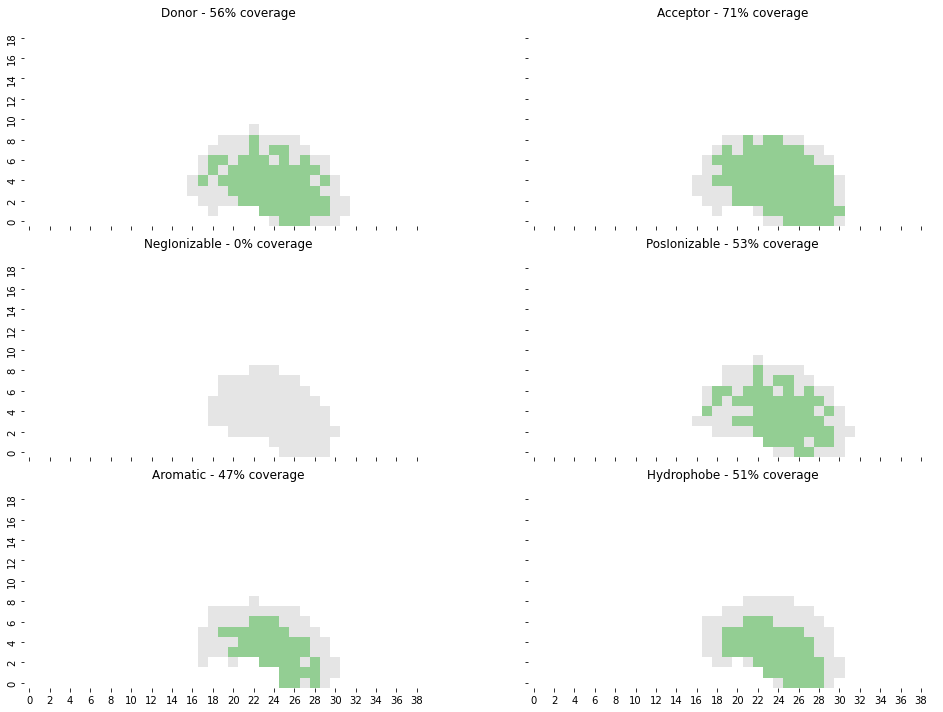

In [30]:
## MaxMin coverage
fig = classic_selection.SimulateCoverage(molnames = MaxMin_molnames)

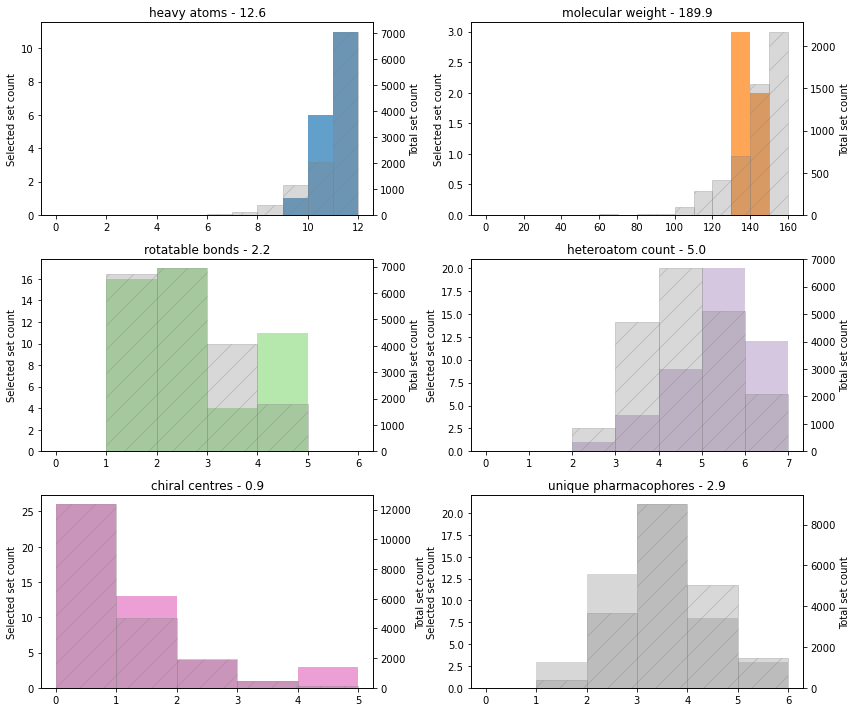

In [31]:
fig = classic_selection.VisualisePropertyDistribution(override_selected_IDs = MaxMin_molnames)

# K-means clustering

> - Perform k-Means clustering on morgan2 fingerprints (equivalent to ECFP4)


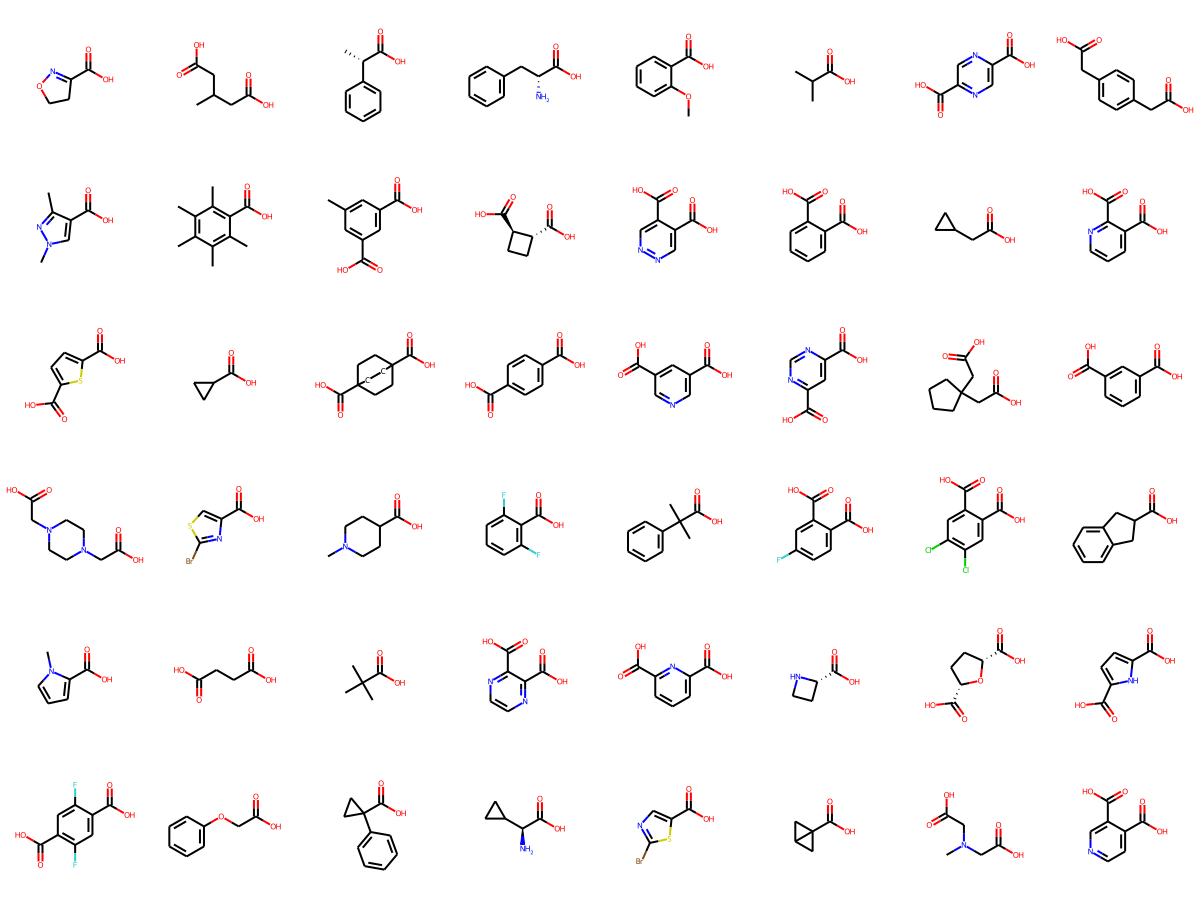

In [32]:
## Convert fingerprints into a list
fps_list = [list(fp) for fp in fps]

## Set the selection size e.g. number of k-means clusters
num_clusters = n_select

## Initialise the k-means clustering object
km = KMeans(
    n_clusters=num_clusters, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=3)

## Perform k-means clustering
y_km = km.fit(fps_list)

## Number of iterations. If less that max_iter, convergence has been met
# y_km.n_iter_

## Get the clusters and the values of the centroids
m_clusters = y_km.labels_.tolist()
centers = np.array(y_km.cluster_centers_)

## Find the data point closest to the cluster centroid
k_means_molnames = []
k_means_picks = [] ## Indices of selection

## Iterate over the clusters

for i in range(num_clusters):
    ## Get the centroid vector
    center_vec = centers[i]
    
    ## Get the indices of the data points that are within each cluster
    data_idx_within_i_cluster = [ idx for idx, cluster_num in enumerate(m_clusters) if cluster_num == i ]
    
    ## Create a matrix where the number of rows = number of points in cluster and is the legnth of the data vector (length of fingerprint)
    ## This is a 'slice' of the data within the original data set which come from the cluster
    one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
    
    ## Iterate over the compounds within the cluster
    for row_num, data_idx in enumerate(data_idx_within_i_cluster):
        
        ## Get the fingerprint for the compound
        one_row = fps_list[data_idx]
        
        ## Set the fingerprint within the matrix
        one_cluster_tf_matrix[row_num] = one_row
    
    ## Calculate the closest compound to the centroid vector
    closest, distance = pairwise_distances_argmin_min(center_vec.reshape(1, -1), one_cluster_tf_matrix)
    
    ## Get the index of the closest compound to the centroid vector in the slice cluster list
    closest_idx_in_one_cluster_tf_matrix = closest[0]
    
    ## Get the index of the closest compound in the larger data set
    closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
    
    ## Get the molname
    data_id = molnames[closest_data_row_num]
    
    k_means_picks.append(closest_data_row_num)
    k_means_molnames.append(data_id)

k_means_molnames = list(set(k_means_molnames))
Draw.MolsToGridImage([mols[x] for x in k_means_picks], subImgSize=(150,150), molsPerRow=8, maxMols=100)

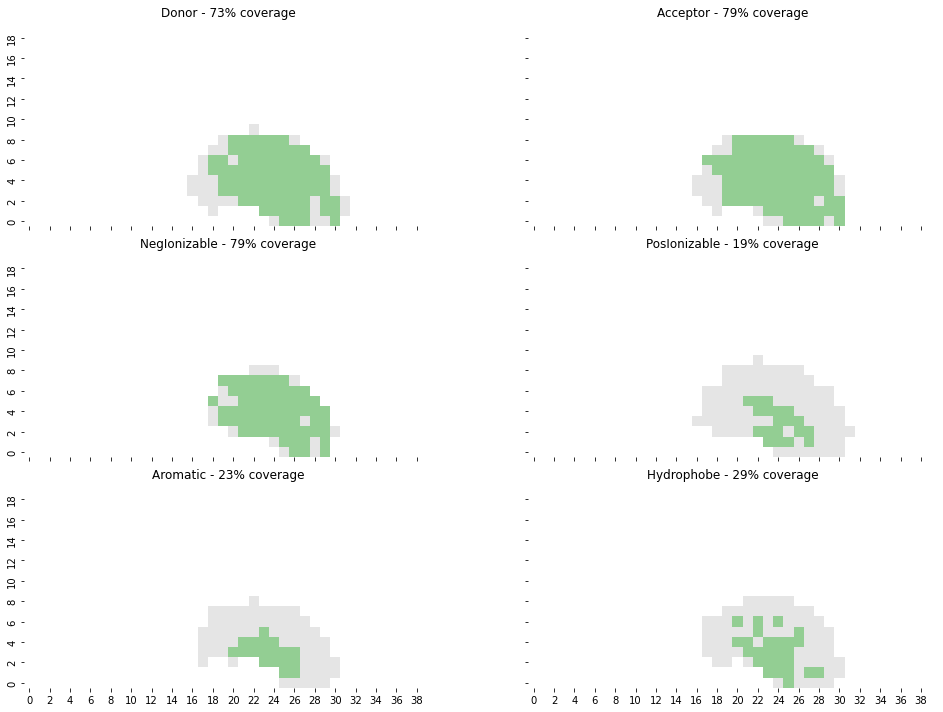

In [33]:
## k_means coverage
fig = classic_selection.SimulateCoverage(molnames = k_means_molnames)

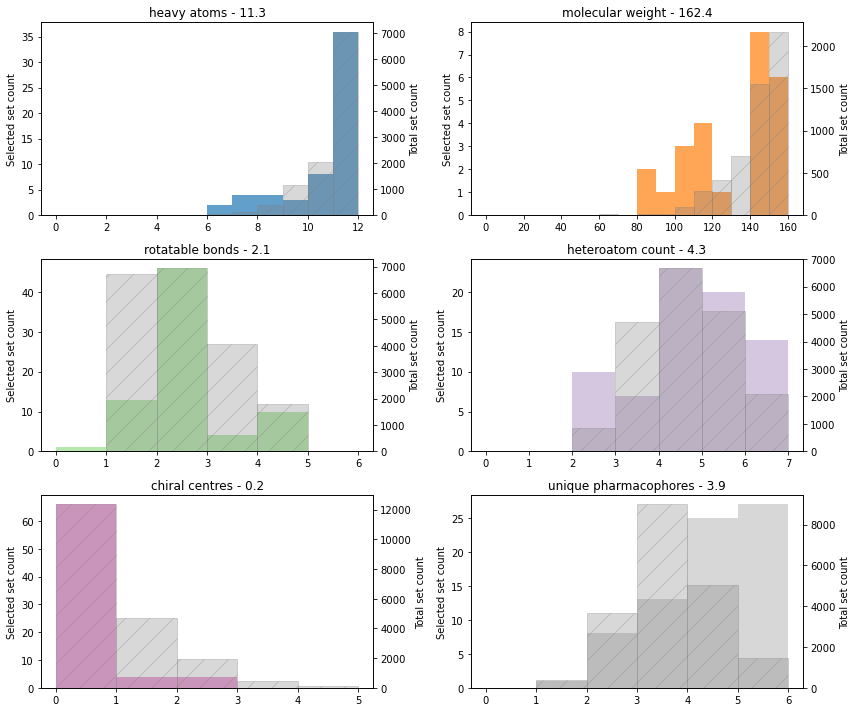

In [34]:
fig = classic_selection.VisualisePropertyDistribution(override_selected_IDs = k_means_molnames)

## Morgan2 Tanimoto similarity distribution histograms
> - These histograms show a histogram of the Tanimoto similarities between all of the selected compounds vs the set of selected compounds
> - They take quite a while to calculate because comparing to the total set - so these are calculated last.

In [35]:
def similarity_histogram(pick_indices, fps, header = "", values = False, **kwargs):
    dist_hist=[]
    for i in range(len(pick_indices)):
        for j in range(i+1,len(pick_indices)):
            dist_hist.append(DataStructs.TanimotoSimilarity(fps[pick_indices[i]],fps[pick_indices[j]]))
    _ = plt.hist(dist_hist,bins=20,range=(0,1),**kwargs)
    _ = plt.title(header)
    _ = plt.xlabel("Similarity")
    if values:
        return dist_hist

In [39]:
# Histogram of overall similarity of set.. Takes long to calculate so precalculated and loaded

#all_indices = [x for x, y in enumerate(fps)]
#full_set_similarity_values = similarity_histogram(all_indices, fps, header = 'Total set', values = True, linewidth = 1)

full_set_similarity_values = []
with open('../data/enamine_acids/enamine_acids_tanimoto_similarities.txt', 'r') as outfile:
    for line in outfile:
        full_set_similarity_values.append(float(line.strip()))

### bbSelect: SOM-partitioning selection vs total set
> - bbSelect SOM partitioning tend to be more similar than the overall similarities

Text(0, 0.5, 'Total set count')

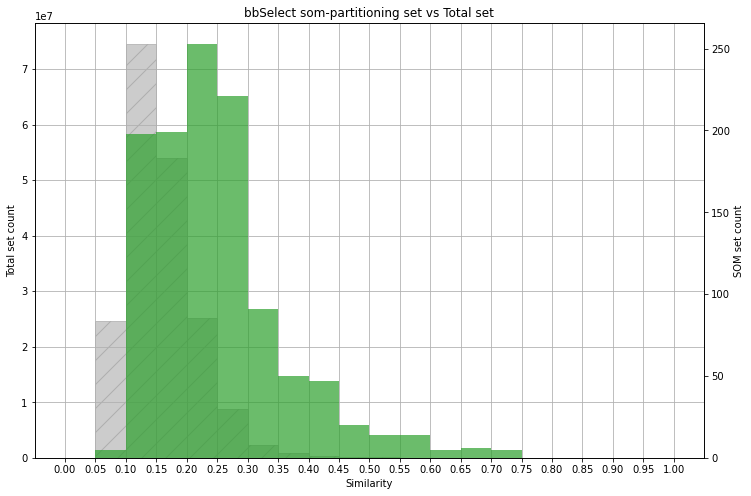

In [40]:
fig, ax1 = plt.subplots(figsize = (12,8))


## Get the indices in the list of the selected compounds
som_picks = [list(molnames).index(i) for i in som_selected_molnames]
som_sim_values = similarity_histogram(som_picks, fps, values = True)
#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(som_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.2))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('bbSelect som-partitioning set vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('SOM set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### bbSelect: Classic-partitioning selection vs total set
> - bbSelect Classic partitioning tend to be more similar than the overall similarities

Text(0, 0.5, 'Total set count')

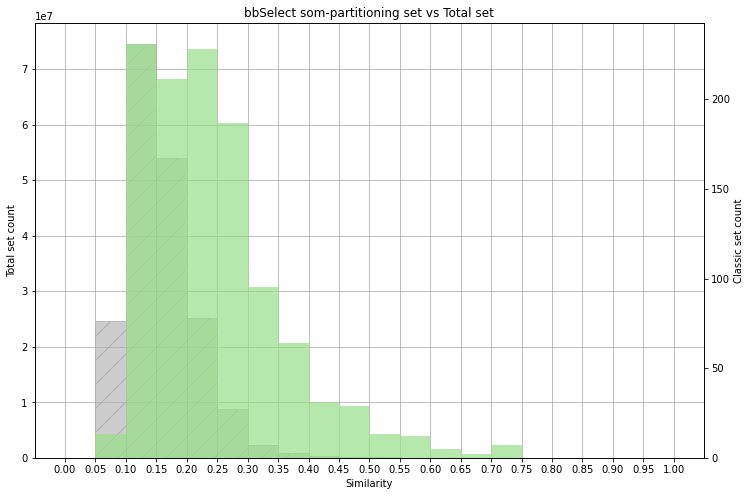

In [41]:
fig, ax1 = plt.subplots(figsize = (12,8))

## Get the indices in the list of the selected compounds
classic_picks = [list(molnames).index(i) for i in classic_selected_molnames]
classic_sim_values = similarity_histogram(classic_picks, fps, values = True)
#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(classic_sim_values, bins=20, range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.25))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('bbSelect som-partitioning set vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Classic set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### bbSelect: Full coverage selection vs total set
> - bbSelect Classic partitioning tend to be more similar than the overall similarities

Text(0, 0.5, 'Total set count')

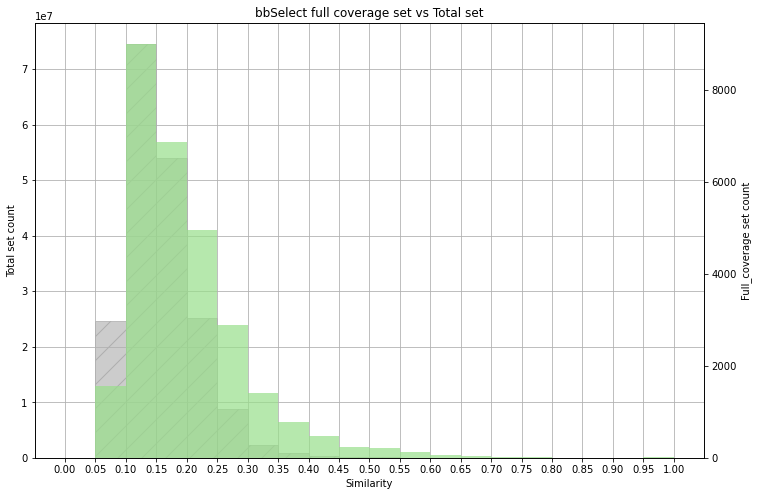

In [42]:
fig, ax1 = plt.subplots(figsize = (12,8))

## Get the indices in the list of the selected compounds
full_coverage_picks = [list(molnames).index(i) for i in full_selected_molnames]
full_sim_values = similarity_histogram(full_coverage_picks, fps, values = True)
#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(full_sim_values, bins=20, range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.25))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('bbSelect full coverage set vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Full_coverage set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### Random selection vs total set
- Reflective of distribution of overall set

Text(0, 0.5, 'Total set count')

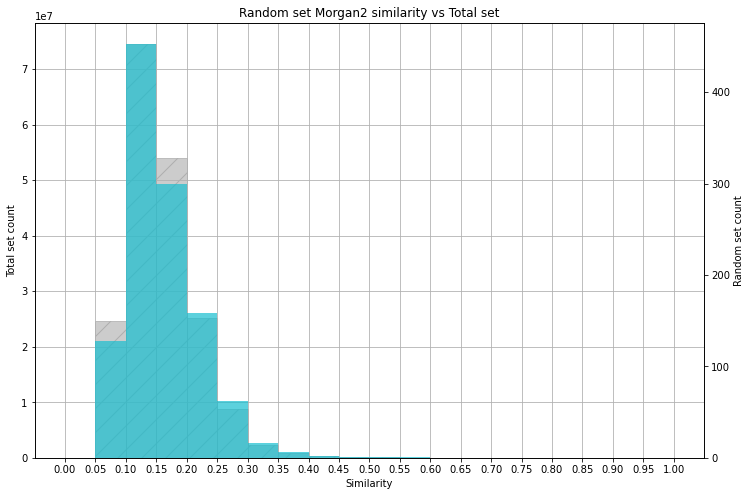

In [43]:
fig, ax1 = plt.subplots(figsize = (12,8))
random_similarity_values = similarity_histogram(random_picks, fps, values = True)
ax2 = ax1.twinx()
ax2.hist(random_similarity_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.9))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('Random set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Random set count')
ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### Sphere exclusion selection vs total set
- lower similarity distribution than overall set with max of 0.25 similarity

Text(0, 0.5, 'Total set count')

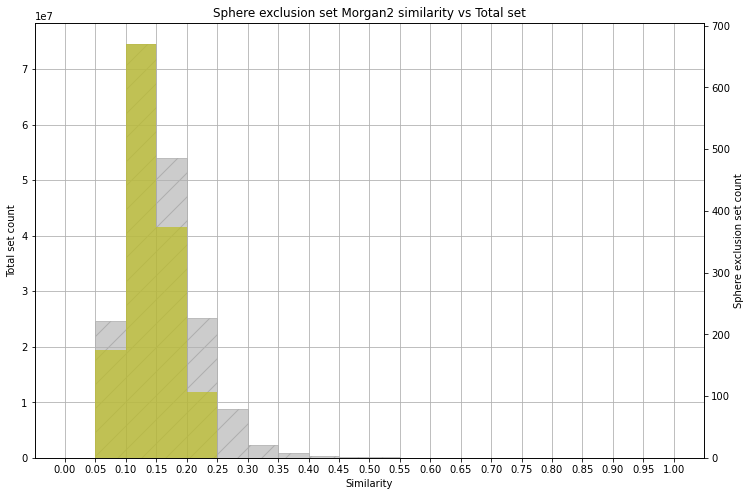

In [44]:
fig, ax1 = plt.subplots(figsize = (12,8))
sphex_sim_values = similarity_histogram(sphex_picks, fps, values = True)
#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(sphex_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.8))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('Sphere exclusion set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Sphere exclusion set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### MaxMin selection vs total set
- lower similarity distribution than overall set with max of 0.25 similarity

Text(0, 0.5, 'Total set count')

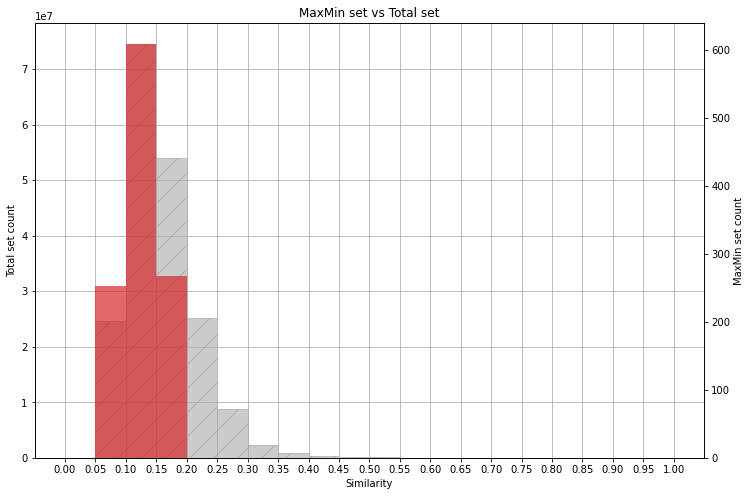

In [45]:
fig, ax1 = plt.subplots(figsize = (12,8))
maxmin_similarity_values = similarity_histogram(MaxMin_picks, fps, values = True)
ax2 = ax1.twinx()
ax2.hist(maxmin_similarity_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.3))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('MaxMin set vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('MaxMin set count')

ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

### k-Means selection vs total set
- lower similarity distribution than overall set with max of 0.25 similarity

Text(0, 0.5, 'Total set count')

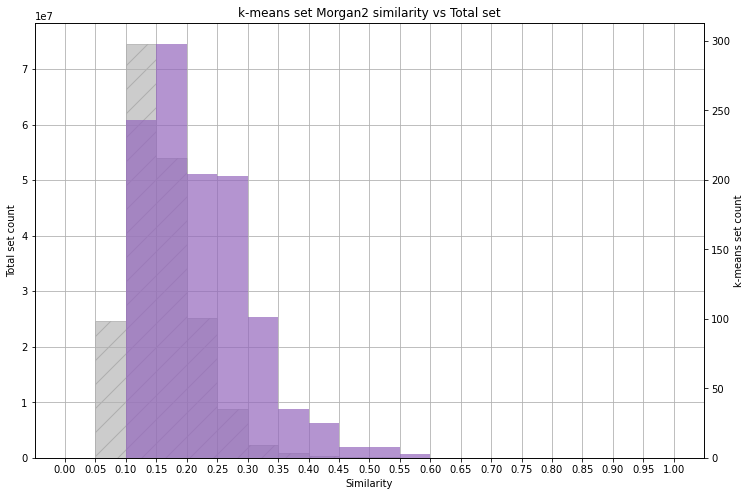

In [46]:
fig, ax1 = plt.subplots(figsize = (12,8))
kmeans_sim_values = similarity_histogram(k_means_picks, fps, values = True)
#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(kmeans_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.4))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('k-means set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('k-means set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

# What is the overlap between the selections?
- This shows the number of compounds in common each of the selection methods have with mGAP

In [47]:
selected_molname_dict = {'som' : som_selected_molnames, 
                        'classic' : classic_selected_molnames,
                        'random' : random_molnames,
                        'full_coverage' : full_selected_molnames,
                        'sphere exclusion' : sphex_molnames,
                        'maxMin' : MaxMin_molnames,
                        'k-Means' : k_means_molnames,}

In [48]:
from itertools import combinations

print(f'Overlaps between selected sets:')

for method, method_comp in list(combinations(list(selected_molname_dict.keys()),2)):
    
    print(f'{method} & {method_comp} : {len(set(selected_molname_dict[method]) & set(selected_molname_dict[method_comp]))}')

            

Overlaps between selected sets:
som & classic : 26
som & random : 1
som & full_coverage : 37
som & sphere exclusion : 2
som & maxMin : 0
som & k-Means : 4
classic & random : 1
classic & full_coverage : 36
classic & sphere exclusion : 2
classic & maxMin : 0
classic & k-Means : 5
random & full_coverage : 1
random & sphere exclusion : 0
random & maxMin : 1
random & k-Means : 1
full_coverage & sphere exclusion : 2
full_coverage & maxMin : 0
full_coverage & k-Means : 8
sphere exclusion & maxMin : 0
sphere exclusion & k-Means : 0
maxMin & k-Means : 0
